<a href="https://colab.research.google.com/github/VPonomarev42/LearningRep/blob/bootstap_2_lesson/stats/bootstrap/aa_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

**Описание колонок**
 - experimentVariant – вариант эксперимента
 - version – версия приложения
 - purchase – факт покупки
 
**Задача**    
1. Запустите A/A-тест
2. Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
3. Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
4. Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста



---

---





## 1. Загрузим и посмотрим на данные

In [2]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';', index_col=0)
data

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


## 2. Проведём А/А тест

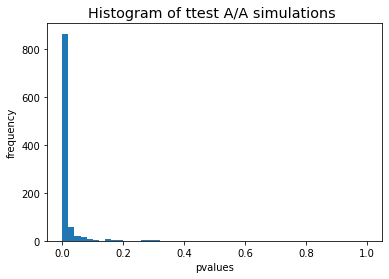

Показатель FPR = 0.938, что значительно больше установленного уровня альфа = 0.05


In [3]:
simulations = 1000
n_s = 1000
res = []

exp1 = data.query('experimentVariant == 0').purchase
exp2 = data.query('experimentVariant == 1').purchase

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = exp1.sample(n_s, replace = False).values
    s2 = exp2.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print(f"Показатель FPR = {sum(np.array(res) <0.05) / simulations}, что значительно больше установленного уровня альфа = 0.05")

## 3. Исследуем данные на наличие ошибок

In [4]:
data.version.unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

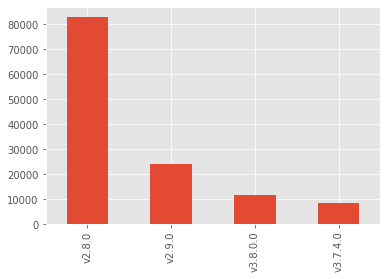

In [5]:
data.version.value_counts().plot.bar()

Посмотрим на соотношения между группами

In [6]:
#не сообразил, как запустить StratifiedTable :(
    
#from statsmodels.stats.contingency_tables import StratifiedTable

#StratifiedTable.from_data('version', 'purchase', 'experimentVariant' ,data).summary()

pd.crosstab(data.version, data.purchase, margins=True, margins_name='Total')

purchase,0,1,Total
version,,,
v2.8.0,80899,1936,82835
v2.9.0,22206,1748,23954
v3.7.4.0,7907,518,8425
v3.8.0.0,11092,712,11804
Total,122104,4914,127018


Проверим распределение событий и покупок между разными версиями приложений, посчитаем конверсию.

In [7]:
data_conversion = data.groupby('version').agg({'purchase':'sum', 'experimentVariant':'count'})\
    .rename(columns={'purchase':'sum_of_purchase', 'experimentVariant':'quantity_of_events'})
    
data_conversion['conversion'] = data_conversion['sum_of_purchase'] / data_conversion['quantity_of_events'] * 100
data_conversion

,sum_of_purchase,quantity_of_events,conversion
version,,,
v2.8.0,1936,82835,2.337176
v2.9.0,1748,23954,7.297320
v3.7.4.0,518,8425,6.148368
v3.8.0.0,712,11804,6.031854


Видно, что конверсия для версии приложения **v2.8.0** значимо отличается от конверсии приложения версии **v2.9.0**. Также количество событий для **v2.8.0** версии приложения в несколько раз превышает количество версий во версии **v2.9.0**. Первый звоночек

Проверим данные отдельно по экспериментам

In [8]:
data_conversion = data.query('experimentVariant == 1').groupby('version').agg({'purchase':'sum', 'experimentVariant':'count'})\
    .rename(columns={'purchase':'sum_of_purchase', 'experimentVariant':'quantity_of_events'})
    
data_conversion['conversion'] = data_conversion['sum_of_purchase'] / data_conversion['quantity_of_events'] * 100
data_conversion

,sum_of_purchase,quantity_of_events,conversion
version,,,
v2.8.0,1895,41552,4.560551
v2.9.0,858,12033,7.130391
v3.7.4.0,266,4221,6.301824
v3.8.0.0,384,6110,6.284779


In [9]:
data_conversion = data.query('experimentVariant == 0').groupby('version').agg({'purchase':'sum', 'experimentVariant':'count'})\
    .rename(columns={'purchase':'sum_of_purchase', 'experimentVariant':'quantity_of_events'})
    
data_conversion['conversion'] = data_conversion['sum_of_purchase'] / data_conversion['quantity_of_events'] * 100
data_conversion

,sum_of_purchase,quantity_of_events,conversion
version,,,
v2.8.0,41,41283,0.099314
v2.9.0,890,11921,7.465817
v3.7.4.0,252,4204,5.994291
v3.8.0.0,328,5694,5.760450


В обоих экспериментах в группе данных с версией приложения **v2.8.0** очень мало данных по конверсии, особенно в первом эксперименте, при значительном объеме событий. Из-за этого получается сильно перекошенное соотношения данных между подгруппами

## 4. Исключим некорректную версию из выборки и повторим эксперимент

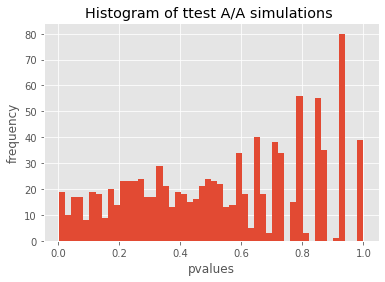

Показатель FPR = 0.035, что меньше установленного уровня альфа = 0.05


In [16]:
simulations = 1000
n_s = 1000
res = []

exp1 = data.query('experimentVariant == 0 & version != "v2.8.0"').purchase
exp2 = data.query('experimentVariant == 1 & version != "v2.8.0"').purchase

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = exp1.sample(n_s, replace = False).values
    s2 = exp2.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print(f"Показатель FPR = {sum(np.array(res) <0.05) / simulations}, что меньше установленного уровня альфа = 0.05")

## Выводы

Результаты А/А теста показали, что текущая система сплитирования работает некорректно: версия приложения **v2.8.0** содержала малое количество конверсий с учётом общего количества событий по отношению к другим версиям приложения.В дальнейшем стоит провести исследование причины такого поведения

После исключения данной версии приложения из обеих эксперементальных выборок и повтора А/А теста показатель **FPR** стал меньше установленного уровня точности альфа, что говорит нам об успешности А/А теста и корректности системы сплитирования.